In [ ]:
!pip install -U fvcore

In [2]:
# TODO: Define here your training and validation loops.
#models for normal jupyter 
#from datasets.cityscapes import CityScapes
#from models.bisenet.build_bisenet import BiSeNet
#from utils_semantic_segmentation.utils import poly_lr_scheduler

from datasets.cityscapes import CityScapes
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from models.bisenet.build_bisenet import BiSeNet
from utils import poly_lr_scheduler

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=19):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                #print("true class size",true_class.shape)
                #print("true label size",true_label.shape)
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image
def train(model,optimizer, train_loader, criterion):
    model.train()
    running_loss = 0.0
    iou_score=0.0
    accuracy=0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.float()
        targets = targets.squeeze()
        #Compute prediction and loss
        outputs,_,_ = model(inputs)
        print(batch_idx)
        
        loss = loss_fn(outputs.to(dtype=torch.float32), targets.to(dtype=torch.int64))
        iou_score += mIoU(outputs.to(device), targets.to(device))
        accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
        #BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)

    train_loss = running_loss / len(train_loader)
    iou_score = iou_score / len(train_loader)
    accuracy = accuracy / len(train_loader)
    return train_loss,iou_score,accuracy

# Test loop
# calculate_label_prediction is a flag used to decide wether to calculate or not ground_truth and predicted tensor
def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    iou_score=0.0
    accuracy=0.0
    with torch.no_grad():
        for batch_idx,(inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()
            targets = targets.int()
            #Compute prediction and loss
            outputs = model(inputs)
            print(batch_idx)
            loss = loss_fn(outputs.to(dtype=torch.float32), targets.squeeze().to(dtype=torch.int64))
            iou_score += mIoU(outputs.to(device), targets.to(device))
            accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
            test_loss += loss.item()
    test_loss = test_loss / len(test_loader)
    iou_score = iou_score / len(test_loader)
    accuracy = accuracy / len(test_loader)
    #test_accuracy = 100. * correct / total
    return test_loss,iou_score,accuracy


#dataset_path='/kaggle/input/cityscapes-polito/Cityscapes/Cityscapes/Cityspaces/'
dataset_path='datasets/Cityscapes/Cityscapes/Cityspaces/'
annotation_train=dataset_path+'gtFine/train'
image_train=dataset_path+'images/train'

annotation_val=dataset_path+'gtFine/val'
image_val=dataset_path+'images/val'
resize_transform = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (512,1024))
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
cityscapes_train = CityScapes(annotations_dir=annotation_train, images_dir=image_train,transform=resize_transform)
cityscapes_val = CityScapes(annotations_dir=annotation_val, images_dir=image_val,transform=resize_transform)

train_loader = DataLoader(cityscapes_train, batch_size=16, shuffle=True)
val_loader = DataLoader(cityscapes_val, batch_size=16, shuffle=True)

# Define the model and load it to the device
bisenet = BiSeNet(num_classes=19, context_path='resnet18')
bisenet.to(device)
optimizer = torch.optim.Adam(bisenet.parameters(), lr=0.001)
poly_lr_scheduler(optimizer, 0.01, 1, lr_decay_iter=1, max_iter=300, power=0.9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
print(cityscapes_train.__len__())
epoch_beginning=0
epochs = 50

1572


# Step 2: load model with weights (do it if you want to continue another training

In [ ]:
#####
#####
#important use this block just if you want to start training from specific weight
version=37
path_weights=f"/kaggle/input/bisenet-epoch-37/bisenet_epoch_37_weights.pth"
bisenet = BiSeNet(num_classes=19, context_path='resnet18')
bisenet.to(device)
#bisenet.load_state_dict(torch.load('/kaggle/input/cityscapes-polito/bisenet_epoch_9_weights.pth'))
bisenet.load_state_dict(torch.load(path_weights))
epoch_beginning=version+1
epochs = 50

# Step 3: plot sample from dataset

In [ ]:
plot_loader = DataLoader(cityscapes_train, batch_size=16, shuffle=False)
(input,output)=next(iter(plot_loader))
output.size()
fig, axes = plt.subplots(2, 1)
input_transpose=convert_tensor_to_image(input[0])
output_transpose=convert_tensor_to_image(output[0])
axes[0].imshow(input_transpose)
axes[1].imshow(output_transpose)
plt.show()
print(output_transpose[200][900])


### Calculate FLOPS and number of parameters

In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# -----------------------------
# Initizialize your model here
# -----------------------------
plot_loader = DataLoader(cityscapes_train, batch_size=16, shuffle=True)
(input,output)=next(iter(plot_loader))
height = 512
width = 1024

flops = FlopCountAnalysis(bisenet, input.to(device,dtype=torch.float32))
print(flop_count_table(flops))

## latency and FPS

In [ ]:
import time 
import numpy as np
model=bisenet
model.eval()
fps_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
(inputs, annotations) = next(iter(fps_loader))
inputs=inputs.to(device,dtype=torch.float32)
iterations=1000
latency=np.empty(0)
FPS=np.empty(0)
for i in range(iterations):
    start=time.time()
    output=model(inputs)
    end=time.time()
    latency_i=end-start
    #print(latency_i)
    latency=np.append(latency,latency_i)
    FPS_i=float(1/latency_i)
    FPS=np.append(FPS,FPS_i)
meanLatency=np.mean(latency)
stdLatency=np.std(latency)
meanFPS=np.mean(FPS)
stdFPS=np.std(FPS)


In [ ]:
print (f"mean latency: {meanLatency} seconds")
print(f"std latency: {stdLatency} seconds")
print (f"mean FPS: {meanFPS} fps")
print(f"std FPS: {stdFPS} fps")

# Step 4 training loop

In [ ]:
epoch_beginning=0
epochs = 50
train_iou_list=[]
train_acc_list=[]
train_loss_list=[]

test_iou_list=[]
test_acc_list=[]
test_loss_list=[]
for epoch in range(epoch_beginning,epochs):
    train_loss,train_iou,train_acc=train(bisenet, optimizer, train_loader, loss_fn)
    train_iou_list.append(train_iou)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    file_name='bisenet_epoch_'+str(epoch)+'_weights.pth'
    torch.save(bisenet.state_dict(),file_name)
    test_loss,test_iou,test_acc = test(bisenet, val_loader, loss_fn)
    test_iou_list.append(test_iou)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    print(f"Epoch n.{epoch} - Test loss: {test_loss}")

# Check unique values snippet

In [ ]:
from matplotlib import cm
import torch
from torchvision.io import read_image 
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
test_path='/kaggle/input/cityscapes-polito/Cityscapes/Cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_000164_gtFine_labelTrainIds.png'
image = Image.open(test_path)
    #if(key%100==0): print(key)
image_array = np.array(image)
unique_values = np.unique(image_array)
test=read_image(test_path)
fig, axes = plt.subplots(1, 1)
new_inferno = cm.get_cmap('hsv', 13)
axes.imshow(test.squeeze(0))
#cmap = plt.get_cmap('bwr')
#plt.set_cmap(cmap)
plt.show()
print(unique_values)
print(torch.unique(test))

# Single Prediction Snippet

In [3]:
from torchvision.io import read_image 
import posixpath
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
dataset_path='datasets/Cityscapes/Cityscapes/Cityspaces/'
annotation_val=dataset_path+'gtFine/val'
def make_prediction(model,image_path):
    # set model to evaluation mode
    iou_score=0
    accuracy=0
    model.eval()
    #retrieve image and annotation
    image = read_image(image_path)
    print("image size",image.shape)
    path=image_path.split('/')
    image_name = posixpath.join(path[-2],path[-1])
    annotation_path = posixpath.join(annotation_val, image_name.replace("_leftImg8bit.png","_gtFine_labelTrainIds.png"))
    annotation = read_image(annotation_path)[0:3,:,:]
    print("size",annotation.shape)
    input = resize_transform(image)
    annotation = resize_transform(annotation)
    #annotation=annotation.permute(1, 2, 0)
    #annotation_encoded=RGBtoOneHot(annotation,colorDict)
    annotation_encoded=annotation
    
    #generate prediction
    with torch.no_grad():
        plot_loader = DataLoader(cityscapes_train, batch_size=16, shuffle=False)
        (input_dl,annotation_dl)=next(iter(plot_loader))
        input_dl, annotation_dl = input_dl.to(device), annotation_dl.to(device)
        #input=image
        input=input.float().to(device)
        input_dl=input_dl.float().to(device)
        print("")
        print("generating prediction..")
        #we add unsqueezeto create a batch dimension
        print("input size",input.shape)
        print("input_dl size",input_dl.shape)
        output = model(input.unsqueeze(0))
        output_dl = model(input_dl)
        print("input size",output.shape)
        print("output_dl size",output_dl.shape)
        print("annotation_dl size",annotation_dl.shape)
        annotation_dl=annotation_dl.squeeze()
        #print("output",output.shape)
        #_, preds = torch.max(outputs, 1)
        #loss = loss_fn(output_dl.to(dtype=torch.float64).to(device), annotation_dl.to(dtype=torch.int64).to(device))
        loss = loss_fn(output.to(dtype=torch.float64).to(device), annotation_encoded.to(dtype=torch.int64).to(device))
        iou_score += mIoU(output.to(device), annotation_encoded.to(device))
        accuracy += pixel_accuracy(output.to(device), annotation_encoded.to(device))
        softmax = nn.Softmax(dim=1)
        preds = torch.argmax(softmax(output),axis=1)
    return input,image,annotation,annotation_encoded,preds,iou_score,accuracy
    
	# turn off gradient tracking
	
input,image,annotation,annotation_encoded,preds,iou_score,accuracy=make_prediction(bisenet,'datasets/Cityscapes/Cityscapes/Cityspaces/images/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png')

image size torch.Size([3, 1024, 2048])
size torch.Size([1, 1024, 2048])
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello

generating prediction..
input size torch.Size([3, 512, 1024])
input_dl size torch.Size([16, 3, 512, 1024])
input size torch.Size([1, 19, 512, 1024])
output_dl size torch.Size([16, 19, 512, 1024])
annotation_dl size torch.Size([16, 1, 512, 1024])


annotation size after permutation torch.Size([1, 512, 1024])
annotation encoded size torch.Size([1, 512, 1024])
prediction size after softmax torch.Size([1, 512, 1024])
scueezed preds size torch.Size([512, 1024])


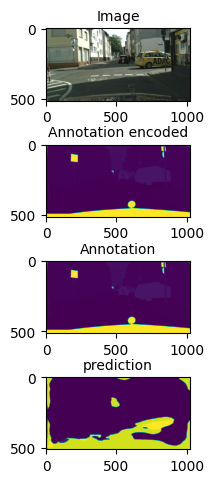

In [4]:
print("annotation size after permutation",annotation.shape)
print("annotation encoded size",annotation_encoded.shape)
#print("prediction size",output.shape)
print("prediction size after softmax",preds.shape)
#visualization
preds_custom=preds.squeeze()
print("scueezed preds size",preds_custom.shape)
fig, axes = plt.subplots(4, 1)
fig.tight_layout()
#axes[0].imshow(image.permute(1, 2, 0))
axes[0].imshow(resize_transform(image).permute(1, 2, 0).cpu())
axes[1].imshow(annotation_encoded.squeeze().cpu())
axes[2].imshow(annotation.squeeze().cpu())
axes[3].imshow(preds_custom.cpu())
axes[0].set_title('Image',fontsize=10)
axes[1].set_title('Annotation encoded',fontsize=10)
axes[2].set_title('Annotation',fontsize=10)
axes[3].set_title('prediction',fontsize=10)
plt.show()

In [ ]:
print(accuracy,iou_score)
print('bisenet_epoch_37_weights')

In [ ]:
all_unique_values = set()

for image_path in cityscapes_train.map_index_to_annotation:
    #image = Image.open(image_path)
    #if(key%100==0): print(key)
    #image_array = np.array(image)
    test=read_image(image_path)
    unique_values = torch.unique(test)
    all_unique_values.update(unique_values)

print(sorted(all_unique_values))